Dataset: https://www.kaggle.com/datasets/osmi/mental-health-in-tech-2016

In [313]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=0.5)


pd.options.display.max_columns = 150

df = pd.read_csv('data/mental.csv')

In [314]:
new_column_names = ['is_self_employed', 'employee_count_bracket', 'is_tech_org', 'role_is_IT', 'empl_provides_mh_cov', 'knows_mh_cov_options',
                    'empl_discussed_mh','empl_offers_mh_rsrcs','anon_protec','if_askfor_mh_medical_leave_how_easy', 'discuss_mh_with_empl_wouldcause_neg_conseq', 'discuss_ph_with_empl_wouldcause_neg_conseq',
                    'comfy_discussing_mh_with_coworkers','comfy_discussing_mh_with_supervisors' , 'empl_takes_mh_asseriously_as_ph', 'observed_neg_conseq_for_coworkers_openabout_mh_inworkspace',
                    'has_medical_cov_incl_mh', 'knowsof_mh_resources','if_diag_would_reveal_toclients/bn_contacts', 'if_reveal_diag_toclient_didthis_impact_neg', 'if_diag_would_reveal_tocoworkers/employees',
                    'if_reveal_diag_tocoworker_didthis_impact_neg', 'productivity_isaffected_by_mh', 'percentage_worktime_affected_by_mh', 'has_prev_employers','prev_empl_provided_mh_benefits',
                    'was_aware_of_prevemployers_mhcare_options','prev_empl_discussed_mh', 'prev_empl_provided_mh_rsrc', 'prev_anon_protec', 'prev_discuss_mh_with_empl_wouldcause_neg_conseq',
                    'prev_discuss_ph_with_empl_wouldcause_neg_conseq', 'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors',
                    'prev_empl_takes_mh_asseriously_as_ph', 'prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace', 'willingto_bringup_ph_interview', 'why', 'willingto_bringup_mh_interview',
                    'why2', 'believes_beingident_as_mh_wouldhurt_career', 'thinks_coworkers_wouldviewthem_neg_if_mh', 'howwilling_share_mh_with_friendsfamily',
                    'observed_badly_handled_response_to_mh_inworkplace', 'observed_madethem_notwantto_talk_about_mh', 'has_family_history_mh', 'hashad_mh_inpast', 'HAS_MH', 'diagnoses_notprof',
                    'conditions_suspected', 'hasbeen_diag_byprof', 'diagnoses_prof', 'sought_treatment', 'mh_interferes_w/work_effective_trt', 'mh_interferes_w/work_ineffective_trt',
                    'age', 'sex', 'country_livesin', 'us_state_livesin', 'country_worksin', 'us_state_worksin', 'work_position', 'is_remote_working']

df.columns = new_column_names

In [315]:
"""Dropping stuff"""


why_cols = [columns for columns in df.columns if 'why' in columns]

#dropping 'why' questions, as each one of them is too unique
for column in why_cols:
    df.drop(column, axis='columns', inplace=True)

#most people (all but 26) work in the same country as they live. this info will still be preserved in remote working column. dropping the country_livesin_column
df.drop('country_livesin', axis='columns', inplace=True)

#1. US state is not informative, 2. This analysis won't focus on particular MH conditions, as they will explode the dataset
df.drop(['us_state_livesin', 'us_state_worksin', 'diagnoses_prof'], axis='columns', inplace=True)

#dropping rows with 25 missing values or more
df = df.loc[df.isna().sum(axis=1) < 25]

#dropping columns with clear majority missing values
df.drop(['knowsof_mh_resources', 'if_diag_would_reveal_toclients/bn_contacts', 'if_reveal_diag_toclient_didthis_impact_neg', 'if_diag_would_reveal_tocoworkers/employees', 'if_reveal_diag_tocoworker_didthis_impact_neg',
         'productivity_isaffected_by_mh','percentage_worktime_affected_by_mh'], axis='columns', inplace=True)

#dropping non-professional and self-diagnoses - 1. because mostly are missing anyway and 2. self diagnoses can are very innaccurate
df.drop(['diagnoses_notprof', 'conditions_suspected'], axis='columns', inplace=True)

#dropping the columns for the answer is "I don't know"
df.drop(['empl_takes_mh_asseriously_as_ph', 'anon_protec', 'prev_anon_protec'], axis='columns', inplace=True)

In [316]:
#Replacing gender names to a male/female/other convention
df['sex'].replace(to_replace=['Male', 'male', 'Male ','M','m','man','Male.','male 9:1 female, roughly','Male (cis)','Sex is male','Man',
                              'cis male','Malr','Dude',"I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
                              'mail', 'M|', 'Male/genderqueer','male ','Cis Male', 'Male (trans, FtM)','cisdude','cis man','MALE','Cis male'], value='MALE', inplace=True)

df['sex'].replace(to_replace=['Female', 'female', 'I identify as female.','female ','Female assigned at birth ','F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F',
                                        'Female or Multi-Gender Femme', 'Female ', 'woman', 'female/woman','Cisgender Female','genderqueer woman','mtf','fem', 'Female (props for making this a freeform field, though)',
                                        ' Female','Cis-woman','Transgender woman'
                                        ],value='FEMALE', inplace=True)

df['sex'].replace(to_replace=['Bigender', 'non-binary',
       'Genderfluid (born female)', 'Other/Transfeminine', 'Androgynous', 'Other', 'nb masculine', 'none of your business',
       'genderqueer', 'Human', 'Genderfluid', 'Enby', 'Queer', 'Agender',
       'Fluid', 'Nonbinary', 'human', 'Unicorn', 'Genderqueer',
       'Genderflux demi-girl', 'female-bodied; no feelings about gender',
       'AFAB'], value='OTHER', inplace=True)

In [317]:
def show_value_counts(df):
    for column in df.columns:
        print(df[column].value_counts(), end='\n\n')

In [318]:
#majority from USA, UK, CD, GER, NED, AUS - dropping others for now
df['country_worksin'].value_counts()
df = df.loc[df['country_worksin'].isin(['United States of America', 'United Kingdom', 'Canada', 'Germany', 'Netherlands', 'Australia'])]

In [319]:
def has_tech_role(row):
    
    tech_roles = ['Back-end Developer', 'Front-end Developer','DevOps/SysAdmin', 'Dev Evangelist/Advocate']
    
    for role in tech_roles:
        if role in row['work_position']:
            return 'Yes'
    
    return 'No'

df['has_tech_role'] = df.apply(lambda row: has_tech_role(row), axis=1)
df.drop('role_is_IT', axis='columns', inplace=True)

In [320]:
def get_new_bracket(row):
    bracket = row['employee_count_bracket']
    
    if bracket in ['1-5', '6-25']:
        return '1-25'
    
    elif bracket in ['26-100', '100-500']:
        return '26-500'
    
    elif bracket in ['500-1000', 'More than 1000']:
        return '500 or more'
    
    else:
        return bracket
        

df['employee_count_bracket'] = df.apply(lambda row: get_new_bracket(row), axis=1) 

In [322]:
#columns that will have missing values for self-employed respondents (209 people)
excluded_for_self_employed = ['employee_count_bracket', 'empl_provides_mh_cov', 'is_tech_org', 'empl_discussed_mh', 'empl_offers_mh_rsrcs',
                               'anon_protec', 'if_askfor_mh_medical_leave_how_easy', 'discuss_mh_with_empl_wouldcause_neg_conseq',
                              'discuss_ph_with_empl_wouldcause_neg_conseq', 'comfy_discussing_mh_with_coworkers', 'comfy_discussing_mh_with_supervisors',
                              'observed_neg_conseq_for_coworkers_openabout_mh_inworkspace', 'observed_badly_handled_response_to_mh_inworkplace']

#columns that will have missing values for respondents with no previous employers (104 people)
excluded_for_no_prev_employers = ['prev_empl_provided_mh_benefits', 'was_aware_of_prevemployers_mhcare_options', 'prev_empl_discussed_mh', 'prev_empl_provided_mh_rsrc',
                                  'prev_anon_protec', 'prev_discuss_mh_with_empl_wouldcause_neg_conseq', 'prev_discuss_ph_with_empl_wouldcause_neg_conseq',
                                  'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors', 'prev_empl_takes_mh_asseriously_as_ph',
                                  'prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace']

In [323]:
#replacing the relevant missing values with 'N/A' - not applicable
df.loc[df['is_self_employed'] == 1,       excluded_for_self_employed] = df.loc[df['is_self_employed'] == 1, excluded_for_self_employed].fillna("N/A")
df.loc[df['has_prev_employers'] == 0, excluded_for_no_prev_employers] = df.loc[df['has_prev_employers'] == 0, excluded_for_no_prev_employers].fillna("N/A")

In [324]:
#filling in the 3 remaining with male - safest bet as the overwhelming majority of the respondents are male
df.loc[pd.isna(df['sex']), 'sex'] = df.loc[pd.isna(df['sex']), 'sex'].fillna('MALE')

#assuming the 323 age is a typo on 32
df.loc[df['age'] == 323, 'age'] = 32

#assuming the 3 age is a typo also, filling it in with 30, as it's the mode
df.loc[df['age'] == 3, 'age'] = 30

#I really doubt this person is 99
df.loc[df['age'] == 99, 'age'] = 32

In [325]:
df.loc[pd.isna(df['observed_badly_handled_response_to_mh_inworkplace'])] = df.loc[pd.isna(df['observed_badly_handled_response_to_mh_inworkplace'])].fillna("Maybe/Not sure")

In [326]:
empl_cov_yes_filt = (pd.isna(df['has_medical_cov_incl_mh'])) & (df['empl_provides_mh_cov'] == 'Yes')

#Filling in the missing values for medical coverage - if the employer provides it, means they have it
#df.loc[empl_cov_yes_filt, "has_medical_cov_incl_mh" ] = df.loc[empl_cov_yes_filt, "has_medical_cov_incl_mh" ].fillna(1.0)

#dropping med coverage for now and remaining missing val columns- even with the above commented out step, we still end up with almost 500 missing values
df.drop(['has_medical_cov_incl_mh', 'knows_mh_cov_options', 'observed_madethem_notwantto_talk_about_mh'], axis='columns', inplace=True)

In [327]:
#DROPPING WORK POSITION FOR NOW
df.drop('work_position', axis='columns', inplace=True)

In [328]:
#The following is replacing some of the survey answers with more general ones - we do this because it increases the variance in the respective columns while preserving the underlying information
#A lot of the possible answers, while being different, carry barely any additional useful info as well as blowing up the number of columns after OHE

df['prev_empl_provided_mh_benefits'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['if_askfor_mh_medical_leave_how_easy'].replace({'Somewhat easy': 'Easy', 'Very easy': 'Easy', 'Somewhat difficult': 'Difficult', 'Very difficult': 'Difficult'}, inplace=True)
df['was_aware_of_prevemployers_mhcare_options'].replace({'I was aware of some': 'I was aware', 'Yes, I was aware of all of them': 'I was aware'}, inplace=True)
df['prev_empl_discussed_mh'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['prev_empl_provided_mh_rsrc'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['was_aware_of_prevemployers_mhcare_options'].replace({'N/A (not currently aware)': 'N/A'}, inplace=True)
df['prev_anon_protec'].replace({'Sometimes': 'Yes', 'Yes, always': 'Yes'}, inplace=True)
df['prev_discuss_mh_with_empl_wouldcause_neg_conseq'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['prev_discuss_ph_with_empl_wouldcause_neg_conseq'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['prev_wouldhavebeen_willing_discuss_mh_coworkers'].replace({'Some of my previous employers': 'Some or all of my previous employers', 'Yes, at all of my previous employers': 'Some or all of my previous employers'}, inplace=True)
df['prev_wouldhavebeen_willing_discuss_mh_supervisors'].replace({'Some of my previous employers': 'Some or all of my previous employers', 'Yes, at all of my previous employers': 'Some or all of my previous employers'}, inplace=True)
df['prev_empl_takes_mh_asseriously_as_ph'].replace({'Some did': 'Some or all did', 'Yes, they all did': 'Some or all did'}, inplace=True)
df['prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace'].replace({'Some of them': 'Some or all of them', 'Yes, all of them': 'Some or all of them'}, inplace=True)
df['believes_beingident_as_mh_wouldhurt_career'].replace({'Yes, it has': 'Yes, I think it would', 'No, it has not': "No, I don't think it would"}, inplace=True)
df['thinks_coworkers_wouldviewthem_neg_if_mh'].replace({'No, they do not': "No, I don't think they would", 'Yes, they do': 'Yes, I think they would'}, inplace=True)
df['howwilling_share_mh_with_friendsfamily'].replace({'Somewhat open': 'Open', 'Very open': 'Open', 'Somewhat not open': 'Not open', 'Not open at all': 'Not open'}, inplace=True)
df['mh_interferes_w/work_ineffective_trt'].replace({'Never': 'Rarely'}, inplace=True)
df['observed_badly_handled_response_to_mh_inworkplace'].replace({'Yes, I observed': 'Yes, I observed or experienced', 'Yes, I experienced': 'Yes, I observed or experienced'}, inplace=True)

In [329]:
df['is_tech_org'].replace({0.0: 'No', 1.0: 'Yes'}, inplace=True)
df['is_self_employed'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df['has_prev_employers'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df['sought_treatment'].replace({0: 'No', 1: 'Yes'}, inplace=True)

In [330]:
def get_comfy_ppl_atwork(row):
    comfy_with_coworkers   = row['comfy_discussing_mh_with_coworkers']
    comfy_with_supervisors = row['comfy_discussing_mh_with_supervisors']
    
    if comfy_with_coworkers == comfy_with_supervisors:
        return comfy_with_supervisors
    
    elif {comfy_with_supervisors, comfy_with_coworkers} == {'Yes', 'Maybe'}:
        return 'Maybe'

    else:
        return comfy_with_supervisors
    
def get_willing_discuss_mh_ppl_prevjob(row):
    comfy_with_prev_coworkers = row['prev_wouldhavebeen_willing_discuss_mh_coworkers']
    comfy_with_prev_supervisors = row['prev_wouldhavebeen_willing_discuss_mh_supervisors']
    
    if comfy_with_prev_coworkers == comfy_with_prev_supervisors:
        return comfy_with_prev_coworkers
    
    else:
        return comfy_with_prev_supervisors

#this dilutes these 2 columns a bit, but dimensionality reduction here is priority
df['comfy_discussing_mh_with_ppl_atwork'] = df.apply(lambda row: get_comfy_ppl_atwork(row), axis=1)
df['prev_comfy_discussing_mh_with_ppl_atwork'] = df.apply(lambda row: get_willing_discuss_mh_ppl_prevjob(row), axis=1)

df.drop(['comfy_discussing_mh_with_supervisors', 'comfy_discussing_mh_with_coworkers',
         'prev_wouldhavebeen_willing_discuss_mh_coworkers', 'prev_wouldhavebeen_willing_discuss_mh_supervisors'], axis='columns', inplace=True)

In [339]:
df[['discuss_ph_with_empl_wouldcause_neg_conseq', 'discuss_mh_with_empl_wouldcause_neg_conseq']].sample(30)

,discuss_ph_with_empl_wouldcause_neg_conseq,discuss_mh_with_empl_wouldcause_neg_conseq
924,No,No
710,No,Yes
629,No,Maybe
578,No,No
1096,No,Yes
656,No,Maybe
1182,No,Maybe
763,No,No
858,No,No
61,No,Yes


In [335]:
ph_c = 'discuss_ph_with_empl_wouldcause_neg_conseq'
mh_c = 'discuss_mh_with_empl_wouldcause_neg_conseq'

df.groupby(ph_c)[mh_c].value_counts()

discuss_ph_with_empl_wouldcause_neg_conseq  discuss_mh_with_empl_wouldcause_neg_conseq
Maybe                                       Maybe                                         147
                                            Yes                                            84
                                            No                                              9
N/A                                         N/A                                           209
No                                          No                                            377
                                            Maybe                                         281
                                            Yes                                            74
Yes                                         Yes                                            37
                                            Maybe                                           1
Name: discuss_mh_with_empl_wouldcause_neg_conseq, dtype: int64

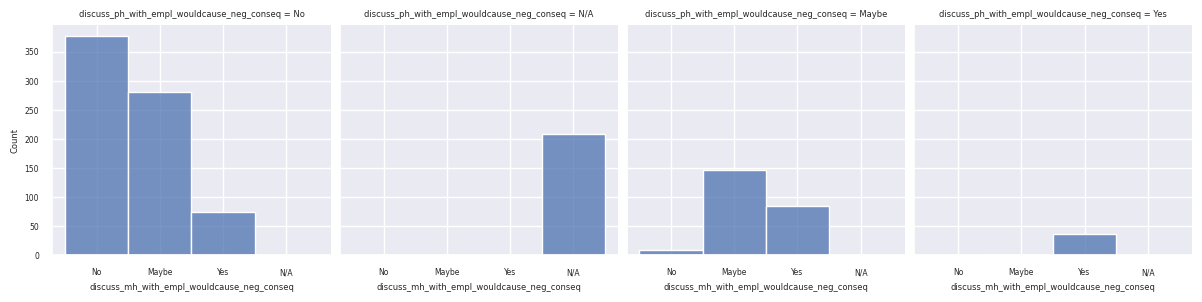

In [337]:
conseq_grid = sns.FacetGrid(data = df, col=ph_c)
conseq_grid.map(sns.histplot, mh_c)

All of the chosen respondents who believe discussing ph would cause neg conseq believe the same for mh.



In [343]:
#This will answer the question - does the respondent feel it is more likely that discussing mh will cause negative consequences
#compared to ph?

def conseq_morelikely_mh_compared_ph(row):
    conseq_mh = row['discuss_mh_with_empl_wouldcause_neg_conseq']
    conseq_ph = row['discuss_ph_with_empl_wouldcause_neg_conseq']

    if conseq_ph == 'N/A' or conseq_mh == 'N/A':
        return 'N/A'
    
    elif conseq_ph == conseq_mh:
        return 'No'
    
    elif conseq_ph == 'No' and conseq_mh in ['Maybe', 'Yes']:
        return 'Yes'
    
    elif conseq_ph == 'Maybe' and conseq_mh == 'Yes':
        return 'Yes'

    else:
        return 'No'
    

def conseq_morelikely_mh_compared_ph(row):
    conseq_mh = row['discuss_mh_with_empl_wouldcause_neg_conseq']
    conseq_ph = row['discuss_ph_with_empl_wouldcause_neg_conseq']

    if conseq_ph == 'N/A' or conseq_mh == 'N/A':
        return 'N/A'
    
    elif conseq_ph == conseq_mh:
        return 'No'
    
    elif conseq_ph == 'No' and conseq_mh in ['Maybe', 'Yes']:
        return 'Yes'
    
    elif conseq_ph == 'Maybe' and conseq_mh == 'Yes':
        return 'Yes'

    else:
        return 'No'
    


#This is clearly what these columns are about
df['morelikely_neg_conseq_for_mh_comparedto_ph'] = df.apply(lambda row: conseq_morelikely_mh_compared_ph(row), axis=1)


    

,discuss_ph_with_empl_wouldcause_neg_conseq,discuss_mh_with_empl_wouldcause_neg_conseq,morelikely_neg_conseq_for_mh_comparedto_ph
529,No,No,No
768,N/A,N/A,N/A
534,N/A,N/A,N/A
898,Maybe,Yes,Yes
653,Yes,Yes,No
1233,Maybe,Maybe,No
83,No,No,No
74,No,No,No
1161,No,No,No
979,No,Maybe,Yes


In [344]:
prev_mh = 'prev_discuss_mh_with_empl_wouldcause_neg_conseq'
prev_ph = 'prev_discuss_ph_with_empl_wouldcause_neg_conseq'

df.groupby(prev_ph)[prev_mh].value_counts()

prev_discuss_ph_with_empl_wouldcause_neg_conseq  prev_discuss_mh_with_empl_wouldcause_neg_conseq
N/A                                              N/A                                                112
None of them                                     Some or all of them                                243
                                                 I don't know                                       165
                                                 None of them                                        79
Some or all of them                              Some or all of them                                506
                                                 I don't know                                       102
                                                 None of them                                        12
Name: prev_discuss_mh_with_empl_wouldcause_neg_conseq, dtype: int64

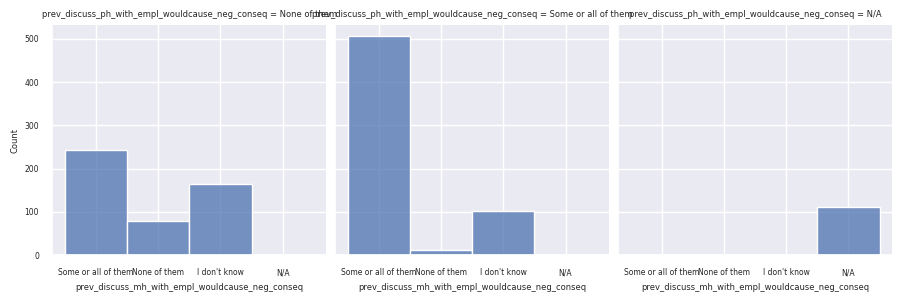

In [346]:
prev_conseq_grid = sns.FacetGrid(data = df, col=prev_ph)
prev_conseq_grid.map(sns.histplot, prev_mh)

In [ ]:
df

,is_self_employed,employee_count_bracket,is_tech_org,empl_provides_mh_cov,empl_discussed_mh,empl_offers_mh_rsrcs,anon_protec,if_askfor_mh_medical_leave_how_easy,discuss_mh_with_empl_wouldcause_neg_conseq,discuss_ph_with_empl_wouldcause_neg_conseq,empl_takes_mh_asseriously_as_ph,observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,has_prev_employers,prev_empl_provided_mh_benefits,was_aware_of_prevemployers_mhcare_options,prev_empl_discussed_mh,prev_empl_provided_mh_rsrc,prev_anon_protec,prev_discuss_mh_with_empl_wouldcause_neg_conseq,prev_discuss_ph_with_empl_wouldcause_neg_conseq,prev_empl_takes_mh_asseriously_as_ph,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,willingto_bringup_ph_interview,willingto_bringup_mh_interview,believes_beingident_as_mh_wouldhurt_career,thinks_coworkers_wouldviewthem_neg_if_mh,howwilling_share_mh_with_friendsfamily,observed_badly_handled_response_to_mh_inworkplace,has_family_history_mh,hashad_mh_inpast,HAS_MH,hasbeen_diag_byprof,sought_treatment,mh_interferes_w/work_effective_trt,mh_interferes_w/work_ineffective_trt,age,sex,country_worksin,is_remote_working,has_tech_role,comfy_discussing_mh_with_ppl_atwork,prev_comfy_discussing_mh_with_ppl_atwork
0,No,26-500,Yes,Not eligible for coverage / N/A,No,No,I don't know,Easy,No,No,I don't know,No,Yes,"No, none did",N/A,I don't know,None did,I don't know,Some or all of them,None of them,I don't know,None of them,Maybe,Maybe,Maybe,"No, I don't think they would",Open,No,No,Yes,No,Yes,No,Not applicable to me,Not applicable to me,39,MALE,United Kingdom,Sometimes,Yes,Maybe,Some or all of my previous employers
1,No,1-25,Yes,No,Yes,Yes,Yes,Easy,No,No,Yes,No,Yes,Some or all did,I was aware,None did,Some or all did,Yes,None of them,None of them,Some or all did,None of them,Maybe,No,"No, I don't think it would","No, I don't think they would",Open,No,Yes,Yes,Yes,Yes,Yes,Rarely,Sometimes,29,MALE,United States of America,Never,Yes,Maybe,Some or all of my previous employers
2,No,1-25,Yes,No,No,No,I don't know,Neither easy nor difficult,Maybe,No,I don't know,No,Yes,"No, none did",N/A,None did,Some or all did,I don't know,I don't know,Some or all of them,I don't know,Some or all of them,Yes,Yes,Maybe,Maybe,Open,Maybe/Not sure,No,Maybe,No,No,Yes,Not applicable to me,Not applicable to me,38,MALE,United Kingdom,Always,Yes,Maybe,I don't know
3,Yes,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Yes,Some or all did,N/A,None did,None did,I don't know,Some or all of them,Some or all of them,I don't know,Some or all of them,Yes,Maybe,"Yes, I think it would",Maybe,Neutral,No,No,Yes,Yes,Yes,Yes,Sometimes,Sometimes,43,MALE,United Kingdom,Sometimes,No,N/A,Some or all of my previous employers
4,No,1-25,No,Yes,No,No,No,Neither easy nor difficult,Yes,Maybe,No,No,Yes,I don't know,N/A,Some or all did,None did,I don't know,Some or all of them,Some or all of them,Some or all did,Some or all of them,Maybe,No,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",Yes,Yes,Yes,Yes,Yes,Sometimes,Sometimes,43,FEMALE,United States of America,Sometimes,Yes,No,Some or all of my previous employers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,No,500 or more,Yes,Yes,No,No,Yes,Easy,No,No,Yes,No,Yes,Some or all did,I was aware,None did,None did,I don't know,Some or all of them,None of them,None did,Some or all of them,No,No,Maybe,"No, I don't think they would",Open,"Yes, I observed or experienced",Yes,Yes,Yes,Yes,Yes,Rarely,Often,38,FEMALE,United States of America,Always,No,Yes,"No, at none of my previous employers"
1428,Yes,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,Yes,Some or all did,I was aware,Some or all did,Some or all did,I don't know,I don't know,None of them,Some or all did,None of them,No,No,Maybe,Maybe,Open,Maybe/Not sure,Yes,No,No,No,Yes,Not applicable to me,Not applicable to me,34,FEMALE,United States of America,Sometimes,No,N/A,

In [ ]:
employed = df.loc[df['is_self_employed'] == 'No'].copy()


self_employed = df.loc[df['is_self_employed'] == 'Yes'].copy()

self_employed.drop(columns = excluded_for_self_employed, inplace=True)

KeyError: "['comfy_discussing_mh_with_coworkers', 'comfy_discussing_mh_with_supervisors'] not found in axis"

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

empl_categorical = employed.drop('age', axis='columns')

ohe = OneHotEncoder(drop='first', max_categories=3, sparse_output=True)

ct = ColumnTransformer(
    transformers=[('encoder', ohe, empl_categorical.columns)],
    remainder='passthrough' 
)

encoded_data = ct.fit_transform(employed)
feature_names = ct.get_feature_names_out()

employed_encoded = pd.DataFrame(encoded_data, columns=feature_names)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaled_age = StandardScaler().fit_transform(employed_encoded['remainder__age'].array.reshape(-1,1))

employed_encoded.drop('remainder__age', axis='columns', inplace=True)
employed_encoded['scaled_age'] = scaled_age

In [ ]:
employed

,is_self_employed,employee_count_bracket,is_tech_org,empl_provides_mh_cov,empl_discussed_mh,empl_offers_mh_rsrcs,anon_protec,if_askfor_mh_medical_leave_how_easy,discuss_mh_with_empl_wouldcause_neg_conseq,discuss_ph_with_empl_wouldcause_neg_conseq,comfy_discussing_mh_with_coworkers,comfy_discussing_mh_with_supervisors,empl_takes_mh_asseriously_as_ph,observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,has_prev_employers,prev_empl_provided_mh_benefits,was_aware_of_prevemployers_mhcare_options,prev_empl_discussed_mh,prev_empl_provided_mh_rsrc,prev_anon_protec,prev_discuss_mh_with_empl_wouldcause_neg_conseq,prev_discuss_ph_with_empl_wouldcause_neg_conseq,prev_wouldhavebeen_willing_discuss_mh_coworkers,prev_wouldhavebeen_willing_discuss_mh_supervisors,prev_empl_takes_mh_asseriously_as_ph,prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace,willingto_bringup_ph_interview,willingto_bringup_mh_interview,believes_beingident_as_mh_wouldhurt_career,thinks_coworkers_wouldviewthem_neg_if_mh,howwilling_share_mh_with_friendsfamily,observed_badly_handled_response_to_mh_inworkplace,has_family_history_mh,hashad_mh_inpast,HAS_MH,hasbeen_diag_byprof,sought_treatment,mh_interferes_w/work_effective_trt,mh_interferes_w/work_ineffective_trt,age,sex,country_worksin,is_remote_working,has_tech_role,comfy_discussing_mh_with_ppl_atwork,prev_comfy_discussing_mh_with_ppl_atwork
0,No,26-500,Yes,Not eligible for coverage / N/A,No,No,I don't know,Easy,No,No,Maybe,Yes,I don't know,No,Yes,"No, none did",N/A,I don't know,None did,I don't know,Some or all of them,None of them,Some or all of my previous employers,Some or all of my previous employers,I don't know,None of them,Maybe,Maybe,Maybe,"No, I don't think they would",Open,No,No,Yes,No,Yes,No,Not applicable to me,Not applicable to me,39,MALE,United Kingdom,Sometimes,Yes,Maybe,Some or all of my previous employers
1,No,1-25,Yes,No,Yes,Yes,Yes,Easy,No,No,Maybe,Yes,Yes,No,Yes,Some or all did,I was aware,None did,Some or all did,Yes,None of them,None of them,"No, at none of my previous employers",Some or all of my previous employers,Some or all did,None of them,Maybe,No,"No, I don't think it would","No, I don't think they would",Open,No,Yes,Yes,Yes,Yes,Yes,Rarely,Sometimes,29,MALE,United States of America,Never,Yes,Maybe,Some or all of my previous employers
2,No,1-25,Yes,No,No,No,I don't know,Neither easy nor difficult,Maybe,No,Maybe,Maybe,I don't know,No,Yes,"No, none did",N/A,None did,Some or all did,I don't know,I don't know,Some or all of them,Some or all of my previous employers,I don't know,I don't know,Some or all of them,Yes,Yes,Maybe,Maybe,Open,Maybe/Not sure,No,Maybe,No,No,Yes,Not applicable to me,Not applicable to me,38,MALE,United Kingdom,Always,Yes,Maybe,I don't know
4,No,1-25,No,Yes,No,No,No,Neither easy nor difficult,Yes,Maybe,Maybe,No,No,No,Yes,I don't know,N/A,Some or all did,None did,I don't know,Some or all of them,Some or all of them,"No, at none of my previous employers",Some or all of my previous employers,Some or all did,Some or all of them,Maybe,No,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",Yes,Yes,Yes,Yes,Yes,Sometimes,Sometimes,43,FEMALE,United States of America,Sometimes,Yes,No,Some or all of my previous employers
5,No,500 or more,Yes,Yes,No,Yes,Yes,Easy,Yes,Yes,Maybe,Yes,No,Yes,Yes,"No, none did",I was aware,None did,None did,I don't know,Some or all of them,Some or all of them,"No, at none of my previous employers","No, at none of my previous employers",None did,Some or all of them,Yes,Maybe,"Yes, I think it would",Maybe,Open,"Yes, I observed or experienced",No,No,Yes,No,Yes,Not applicable to me,Often,42,MALE,United Kingdom,Sometimes,Yes,Maybe,"No, at none of my previous employers"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,No,26-500,Yes,I don't know,No,I don't know,I don't know,Easy,Maybe,No,Maybe

In [ ]:
self_employed_encoded = pd.get_dummies(self_employed, dtype=float, drop_first=True)

In [ ]:
for column in employed_encoded.columns:
    if '_N/A' in column:
        employed_encoded.drop(column, axis='columns', inplace=True)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.18)

new = selector.fit_transform(employed_encoded)

features = selector.get_support(indices=True)
columns = employed_encoded.columns[features]

employed_selected = pd.DataFrame(new, columns=columns)

employed_noage = employed_selected.drop(columns=['scaled_age'])

In [ ]:
employed_selected

,encoder__employee_count_bracket_500 or more,encoder__empl_provides_mh_cov_Yes,encoder__empl_offers_mh_rsrcs_No,encoder__empl_offers_mh_rsrcs_infrequent_sklearn,encoder__anon_protec_Yes,encoder__if_askfor_mh_medical_leave_how_easy_Easy,encoder__if_askfor_mh_medical_leave_how_easy_infrequent_sklearn,encoder__discuss_mh_with_empl_wouldcause_neg_conseq_No,encoder__discuss_ph_with_empl_wouldcause_neg_conseq_No,encoder__comfy_discussing_mh_with_coworkers_No,encoder__comfy_discussing_mh_with_coworkers_infrequent_sklearn,encoder__comfy_discussing_mh_with_supervisors_Yes,encoder__comfy_discussing_mh_with_supervisors_infrequent_sklearn,encoder__empl_takes_mh_asseriously_as_ph_Yes,encoder__empl_takes_mh_asseriously_as_ph_infrequent_sklearn,encoder__prev_empl_provided_mh_benefits_Some or all did,encoder__prev_empl_provided_mh_benefits_infrequent_sklearn,encoder__prev_empl_discussed_mh_Some or all did,encoder__prev_empl_provided_mh_rsrc_Some or all did,encoder__prev_discuss_mh_with_empl_wouldcause_neg_conseq_Some or all of them,encoder__prev_discuss_ph_with_empl_wouldcause_neg_conseq_Some or all of them,encoder__prev_wouldhavebeen_willing_discuss_mh_coworkers_Some or all of my previous employers,encoder__prev_wouldhavebeen_willing_discuss_mh_supervisors_Some or all of my previous employers,encoder__prev_empl_takes_mh_asseriously_as_ph_Some or all did,encoder__prev_empl_takes_mh_asseriously_as_ph_infrequent_sklearn,encoder__prev_observed_neg_conseq_for_coworkers_openabout_mh_inworkspace_Some or all of them,encoder__willingto_bringup_ph_interview_No,encoder__willingto_bringup_ph_interview_infrequent_sklearn,encoder__willingto_bringup_mh_interview_No,"encoder__believes_beingident_as_mh_wouldhurt_career_Yes, I think it would","encoder__thinks_coworkers_wouldviewthem_neg_if_mh_No, I don't think they would",encoder__thinks_coworkers_wouldviewthem_neg_if_mh_infrequent_sklearn,encoder__howwilling_share_mh_with_friendsfamily_Open,"encoder__observed_badly_handled_response_to_mh_inworkplace_Yes, I observed or experienced",encoder__observed_badly_handled_response_to_mh_inworkplace_infrequent_sklearn,encoder__has_family_history_mh_Yes,encoder__hashad_mh_inpast_Yes,encoder__HAS_MH_Yes,encoder__hasbeen_diag_byprof_Yes,encoder__sought_treatment_Yes,encoder__mh_interferes_w/work_effective_trt_Sometimes,encoder__mh_interferes_w/work_effective_trt_infrequent_sklearn,encoder__mh_interferes_w/work_ineffective_trt_Often,encoder__mh_interferes_w/work_ineffective_trt_infrequent_sklearn,encoder__sex_MALE,encoder__country_worksin_United States of America,encoder__is_remote_working_Sometimes,encoder__has_tech_role_Yes,encoder__comfy_discussing_mh_with_ppl_atwork_No,encoder__prev_comfy_discussing_mh_with_ppl_atwork_Some or all of my previous employers,scaled_age
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.691316
1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,-0.580041
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.564180
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.199858
4,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.072723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

0.6761250725756799


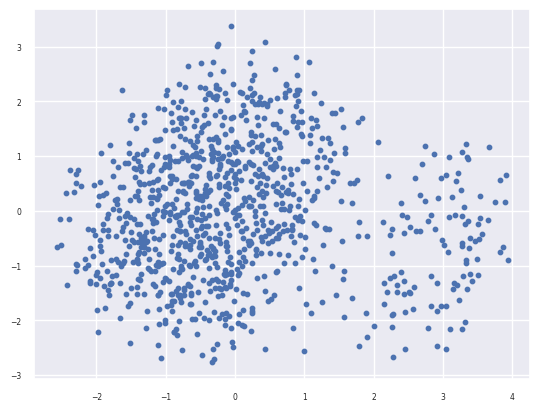

In [ ]:
from sklearn.decomposition import PCA

employed_pca = PCA(n_components=20)
employed_pca.fit(employed_encoded)

print(employed_pca.explained_variance_ratio_.sum())

employed_pca_df = pd.DataFrame(employed_pca.fit_transform(employed_encoded))

plt.scatter(employed_pca_df[0], employed_pca_df[1], s = 10)

In [ ]:
employed_encoded.shape

(1010, 82)

In [ ]:
loadings = employed_pca.components_

# Print the feature loadings
num_pcs = employed_pca.n_components_
num_features = loadings.shape[1]
for pc in range(num_pcs):
    print(f"Principal Component {pc+1}:")
    for feature in range(num_features):
        loading = loadings[pc, feature]
        print(f"Feature {feature+1}: {loading:.4f}")
    print()

Principal Component 1:
Feature 1: -0.0005
Feature 2: 0.0278
Feature 3: -0.0258
Feature 4: -0.0940
Feature 5: 0.0634
Feature 6: -0.0355
Feature 7: -0.0157
Feature 8: 0.0723
Feature 9: -0.0611
Feature 10: -0.0591
Feature 11: 0.0186
Feature 12: -0.0592
Feature 13: 0.0164
Feature 14: -0.0950
Feature 15: 0.0571
Feature 16: -0.0522
Feature 17: 0.0130
Feature 18: 0.1109
Feature 19: -0.0866
Feature 20: -0.1312
Feature 21: 0.1209
Feature 22: -0.0847
Feature 23: 0.0475
Feature 24: 0.0073
Feature 25: -0.1764
Feature 26: -0.2096
Feature 27: 0.2128
Feature 28: -0.0112
Feature 29: -0.1340
Feature 30: 0.1783
Feature 31: -0.1690
Feature 32: 0.1764
Feature 33: -0.1272
Feature 34: 0.1827
Feature 35: -0.1525
Feature 36: 0.1541
Feature 37: -0.0979
Feature 38: 0.1764
Feature 39: -0.2087
Feature 40: 0.1764
Feature 41: -0.2283
Feature 42: 0.2046
Feature 43: -0.1698
Feature 44: 0.1991
Feature 45: -0.1115
Feature 46: 0.1764
Feature 47: 0.0218
Feature 48: -0.0295
Feature 49: 0.0492
Feature 50: -0.0226
Feature 5

In [ ]:
feature_importance = np.abs(loadings).sum(axis=0)

# Sort the features based on their importance
sorted_indices = np.argsort(feature_importance)[::-1]

# Print the most important features
num_features_to_display = 10
for i in range(num_features_to_display):
    feature_index = sorted_indices[i]
    feature_name = employed_encoded.columns[feature_index]
    importance = feature_importance[feature_index]
    print(f"{feature_name}: Importance = {importance:.4f}")

encoder__mh_interferes_w/work_effective_trt_infrequent_sklearn: Importance = 2.5217
scaled_age: Importance = 2.5155
encoder__howwilling_share_mh_with_friendsfamily_Open: Importance = 2.4893
encoder__has_family_history_mh_Yes: Importance = 2.4087
encoder__is_remote_working_Sometimes: Importance = 2.4010
encoder__if_askfor_mh_medical_leave_how_easy_infrequent_sklearn: Importance = 2.3981
encoder__observed_badly_handled_response_to_mh_inworkplace_infrequent_sklearn: Importance = 2.3958
encoder__observed_badly_handled_response_to_mh_inworkplace_Yes, I observed or experienced: Importance = 2.3513
encoder__mh_interferes_w/work_effective_trt_Sometimes: Importance = 2.3165
encoder__prev_discuss_ph_with_empl_wouldcause_neg_conseq_Some or all of them: Importance = 2.2832
